In [1]:
# from keras import backend as K
import keras

import pickle
import numpy as np
import matplotlib.pyplot as plt
# from keras.utils import multi_gpu_model
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import h5py as h5
import keras
from keras.models import load_model
from hrnet_3D import *
# from unet_3D import *
from utils import *
from DataAugment import *
import cv2
import os

2024-05-17 22:09:43.747893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 22:09:43.901702: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 22:09:44.522732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/xchen/cuda/targets/x86_64-linux/lib/:/home/xchen/miniconda3/envs/tf/lib/
2024-05-17 22:09:44.522810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfe

In [2]:
os.environ['PATH'] = '/home/xchen/miniconda3/envs/tf/bin/' + ':' + os.environ['PATH']
# switch to your path:
# os.environ['PATH'] = '/home/jyuan@Okta-eitm.org/anaconda3/envs/tf/bin' + ':' + os.environ['PATH']


In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[4:8], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

8 Physical GPUs, 4 Logical GPU


2024-05-17 22:09:45.632042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 22:09:47.835362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38266 MB memory:  -> device: 4, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:8d:00.0, compute capability: 8.0
2024-05-17 22:09:47.837104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38266 MB memory:  -> device: 5, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:92:00.0, compute capability: 8.0
2024-05-17 22:09:47.838598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/devi

In [4]:
print(tf.__version__)
print('num gpus available:', len(tf.config.experimental.list_physical_devices('GPU')))

batch_size = 3
epochs = 20
depth = 3

2.10.0
num gpus available: 8


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
path = os.getcwd()
print(path)

/home/xchen/projects/MRI


x_train shape: (10, 42, 240, 240, 3)
y_train shape: (10, 42, 240, 240, 1)
x_test shape: (3, 42, 240, 240, 3)
y_test shape: (3, 42, 240, 240, 1)


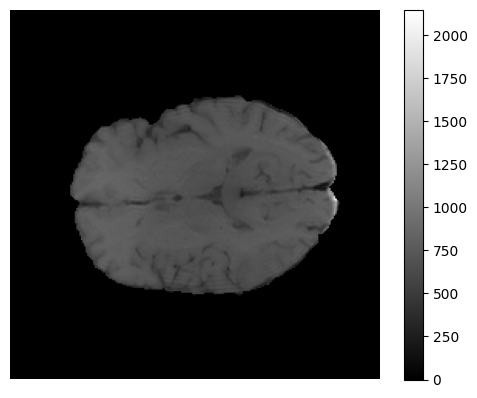

In [7]:
'''load data'''
tr = np.load(path+'/train.npy')
te = np.load(path+'/test.npy')
x_train = tr[:,80:122,:,:,0:3]
y_train = tr[:,80:122,:,:,3:4]
x_test = te[:,80:122,:,:,0:3]
y_test = te[:,80:122,:,:,3:4]
del tr
del te

#
# MRIData = h5.File('/raid/chenchao/code/3DHRNet/Dataset/MRIData_subset_3D_55_175.h5','r')
# x_train = MRIData['x_train']
# y_train = MRIData['y_train']
# x_test = MRIData['x_test']
# y_test = MRIData['y_test']
# x_train = np.array(x_train)
# y_train = np.expand_dims(y_train,axis=-1)
# x_test = np.array(x_test)
# y_test = np.expand_dims(y_test,axis=-1)

start = 0 # initial 50
end = 155  # initial 53
print ('x_train shape:', x_train.shape)
print ('y_train shape:', y_train.shape)

x_test = x_test[:,start:end,:,:,:]
y_test = y_test[:,start:end,:,:,0]
y_test = np.expand_dims(y_test,axis=-1)
print ('x_test shape:', x_test.shape)
print ('y_test shape:', y_test.shape)

# print('x_train:', x_train[0, 50, :, :, 0], np.min(x_train[0, 50, :, :, 0]), np.max(x_train[0, 50, :, :, 0]))
# print('y_train:', y_train[0, 50, :, :, 0], np.min(y_train[0, 50, :, :, 0]), np.max(y_train[0, 50, :, :, 0]))
# print('x_test:', x_test[0, 0, :, :, 0], np.min(x_test[0, 0, :, :, 0]), np.max(x_test[0, 0, :, :, 0]))
# print('y_test:', y_test[0, 0, :, :, 0], np.min(y_test[0, 0, :, :, 0]), np.max(y_test[0, 0, :, :, 0]))
plt.imshow(x_train[0, 10, :, :, 0], cmap='gray')
plt.colorbar()
plt.axis('off')  # 关闭坐标轴
plt.show()



def Generator(x_train,y_train,batch_size):
    m = 0
    n = 0
    depth = 3
    while True:
        m = np.random.choice(x_train.shape[0],batch_size)
        n = 0 #np.random.randint(0,x_train.shape[1]-depth)
        data_x = x_train[m, n:n+depth,:,:,:]
        data_y = y_train[m, n:n+depth,:,:,:]
        yield (data_x,data_y)



In [8]:
# def normalization(x_train):
#   image_dimensions = (2, 3)  # 第2和第3维表示图片
#   # 计算每张图片的最大值和最小值
#   image_max = np.max(x_train, axis=image_dimensions, keepdims=True)
#   image_min = np.min(x_train, axis=image_dimensions, keepdims=True)
#   # 检查是否有全0图片
#   zero_images_mask = np.all(image_max == image_min, axis=image_dimensions)
#   # print(np.where(zero_images_mask == True))
#   # print(zero_images_mask.shape)
#   # print(image_max.shape)
#   x_train_norm = np.zeros_like(x_train)
#   print(x_train_norm.shape)
#   for i in range((x_train_norm.shape[0])):
#     for j in range((x_train_norm.shape[1])):
#       for k in range((x_train_norm.shape[4])):
#         if zero_images_mask[i][j][k] == False:
#           x_train_norm[i, j, :, :, k] = (x_train[i,j,:,:,k] - image_min[i][j][0][0][k]) / (image_max[i][j][0][0][k] - image_min[i][j][0][0][k])
#   return x_train_norm * 255
# def normalization(x_train):
#     image_max = np.max(x_train, axis=(2,3), keepdims=True)
#     image_max = np.tile(image_max[:, :, :, :, :], (1, 1, 240, 240, 1))
#     image_min = np.min(x_train, axis=(2,3), keepdims=True)
#     image_min = np.tile(image_min[:, :, :, :, :], (1, 1, 240, 240, 1))

#     zero_images_mask = np.all(image_max == image_min, axis=(2, 3), keepdims=True)
#     zero_images_mask = np.tile(zero_images_mask[:, :, :, :, :], (1, 1, 240, 240, 1))
#     print(zero_images_mask.shape)
#     x_train_norm = np.zeros_like(x_train)
#     x_train_norm[~zero_images_mask] = (x_train[~zero_images_mask] - image_min[~zero_images_mask]) / (image_max[~zero_images_mask] - image_min[~zero_images_mask])
#     return x_train_norm * 255

def normalization(x_train):
    image_max = np.max(x_train, axis=(2,3), keepdims=True)
    image_max = np.tile(image_max[:, :, :, :, :], (1, 1, 240, 240, 1))
    image_min = np.min(x_train, axis=(2,3), keepdims=True)
    image_min = np.tile(image_min[:, :, :, :, :], (1, 1, 240, 240, 1))
    nonzero = (image_max - image_min) > 0
    x_train_norm = np.zeros_like(x_train)
    x_train_norm[nonzero] = (x_train[nonzero] - image_min[nonzero]) / (image_max[nonzero] - image_min[nonzero])
    return x_train_norm * 255
x_train_norm = normalization(x_train)
y_train_norm = normalization(y_train)
x_test_norm = normalization(x_test)
y_test_norm = normalization(y_test)


x_train_norm shape: (10, 42, 240, 240, 3)
y_train_norm shape: (10, 42, 240, 240, 1)
x_test_norm shape: (3, 42, 240, 240, 3)
y_test_norm shape: (3, 42, 240, 240, 1)


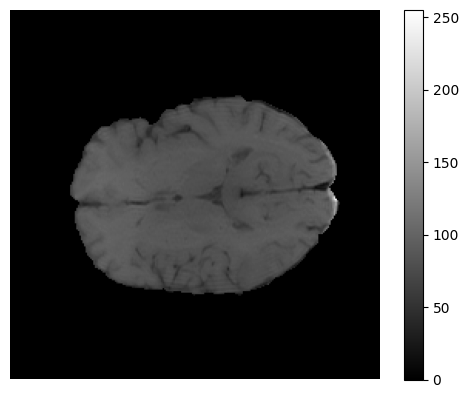

In [9]:
x_train_norm = np.round(x_train_norm)
y_train_norm = np.round(y_train_norm)
x_test_norm = np.round(x_test_norm)
y_test_norm = np.round(y_test_norm)
print ('x_train_norm shape:', x_train_norm.shape)
print ('y_train_norm shape:', y_train_norm.shape)
print ('x_test_norm shape:', x_test_norm.shape)
print ('y_test_norm shape:', y_test_norm.shape)

plt.imshow(x_train_norm[0, 10, :, :, 0], cmap='gray')
plt.colorbar()
plt.axis('off')  # 关闭坐标轴
plt.show()

In [10]:
# 发现 NaN 值
nan_indices = np.isnan(x_train_norm)
print("NaN 值的索引:", np.where(nan_indices)[0])
nan_indices = np.isnan(y_train_norm)
print("NaN 值的索引:", np.where(nan_indices)[0])
nan_indices = np.isnan(x_test_norm)
print("NaN 值的索引:", np.where(nan_indices)[0])
nan_indices = np.isnan(y_test_norm)
print("NaN 值的索引:", np.where(nan_indices)[0])

print(np.max(x_train_norm), np.min(x_train_norm))
print(np.max(y_train_norm), np.min(y_train_norm))
print(np.max(x_test_norm), np.min(x_test_norm))
print(np.max(y_test_norm), np.min(y_test_norm))

NaN 值的索引: []
NaN 值的索引: []
NaN 值的索引: []
NaN 值的索引: []
255.0 0.0
255.0 0.0
255.0 0.0
255.0 0.0


x_train_norm shape: (10, 42, 240, 240, 3)
y_train_norm shape: (10, 42, 240, 240, 1)
x_test_norm shape: (3, 42, 240, 240, 3)
y_test_norm shape: (3, 42, 240, 240, 1)
x_train shape: (140, 3, 240, 240, 3) max: 255.0 min: 0.0
y_train shape: (140, 3, 240, 240, 1) max: 255.0 min: 0.0
x_test shape: (5, 3, 240, 240, 3) max: 255.0 min: 0.0
y_test shape: (5, 3, 240, 240, 1) max: 255.0 min: 0.0


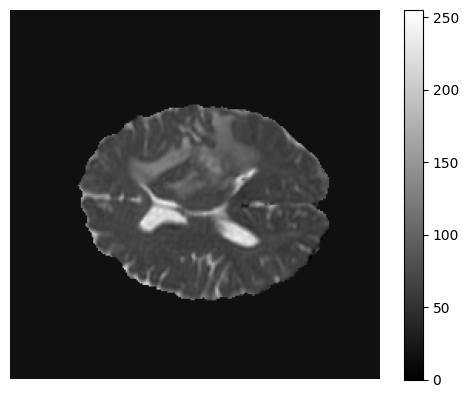

In [11]:
start = 80 # initial 50
end = start + depth  # initial 53
print ('x_train_norm shape:', x_train_norm.shape)
print ('y_train_norm shape:', y_train_norm.shape)
print ('x_test_norm shape:', x_test_norm.shape)
print ('y_test_norm shape:', y_test_norm.shape)
x_train = x_train_norm
y_train = y_train_norm
x_test = x_test_norm[:,:,:,:,:]
y_test = y_test_norm[:,:,:,:,0]

x_train = x_train.reshape(-1,240,240,3)
y_train = y_train.reshape(-1,240,240,1)
x_train = x_train.reshape(140,3,240,240,3)
y_train = y_train.reshape(140,3,240,240,1)

x_test = x_test.reshape(-1,240,240,3)
y_test = y_test.reshape(-1,240,240,1)
x_test = x_test.reshape(42,3,240,240,3)
y_test = y_test.reshape(42,3,240,240,1)
x_test = np.concatenate((x_test[1:3,:,:,:,:], x_test[19:20,:,:,:,:], x_test[36:38,:,:,:,:]), axis=0)
y_test = np.concatenate((y_test[1:3,:,:,:,:], y_test[19:20,:,:,:,:], y_test[36:38,:,:,:,:]), axis=0)
# print(start, end)
# y_test = np.expand_dims(y_test,axis=-1)
print ('x_train shape:', x_train.shape, 'max:', np.max(x_train), 'min:', np.min(x_train))
print ('y_train shape:', y_train.shape, 'max:', np.max(y_train), 'min:', np.min(y_train))
print ('x_test shape:', x_test.shape, 'max:', np.max(x_test),'min:', np.min(x_test))
print ('y_test shape:', y_test.shape, 'max:', np.max(y_test),'min:', np.min(y_test))
plt.imshow(x_test[0, 1, :, :, 2], cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

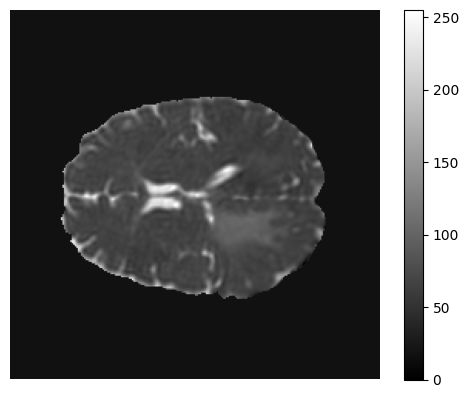

In [12]:
plt.imshow(x_test[2, 1, :, :, 2], cmap='gray')
plt.colorbar()
plt.axis('off')
plt.show()

In [13]:
x_train.shape

(140, 3, 240, 240, 3)

In [14]:
# prep datasets
x_train_data = tf.expand_dims(x_train, axis=-1)
y_train_data = tf.expand_dims(y_train, axis=-1)
x_test_data = tf.expand_dims(x_test, axis=-1)
y_test_data = tf.expand_dims(y_test, axis=-1)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))\
    .batch(batch_size * len(tf.config.list_physical_devices('GPU'))).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))\
    .batch(batch_size * len(tf.config.list_physical_devices('GPU'))).repeat()

In [15]:
# model = unet(batch_size = batch_size, depth=80, height = 240, width = 240, channel = 3, classes =1)
import keras
strategy = tf.distribute.MultiWorkerMirroredStrategy()
print('number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3'), communication = CommunicationImplementation.AUTO
number of devices: 4


In [ ]:
with strategy.scope():
    Model = HRnet(batch_size = batch_size * len(tf.config.list_physical_devices('GPU')), depth=3, height = 240, width = 240, channel = 3, classes =1)  # 在多个 GPU 上创建模型
    # Model.summary()
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='auto', factor=0.2, patience=2, min_lr=0.00000001)
    Adam = keras.optimizers.Adam(learning_rate=0.000001,beta_1=0.9,beta_2=0.999)   # initial learn rate 0.0001     0.00000001 work

    Model.compile(optimizer=Adam, loss=custom_loss, metrics=['MAE'])


    history = Model.fit(train_dataset, validation_steps = 1, steps_per_epoch= 200, epochs=15,verbose=1,validation_data=test_dataset, callbacks=[reduce_lr])

# history = Model.fit_generator(Generator(x_train,y_train,batch_size=12),epochs=50,verbose=1,validation_data=(x_test,y_test), callbacks=[reduce_lr])
# history = Model.fit_generator(Generator(x_train,y_train,batch_size=4),
#                               steps_per_epoch= 1000,       #initial 2000
#                               epochs=100,
#                               verbose=1,
#                               validation_data=(x_test,y_test))
    # history = Model.fit(x_train[:,start:end,:,:,:],y_train[:,start:end,:,:,0:],batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test,y_test), callbacks=[reduce_lr])
score = Model.evaluate(x_test,y_test,batch_size=batch_size)

In [ ]:



########################### Model Construction ######################
# model = HRnet(batch_size = batch_size, depth=3, height = 256, width = 192, channel = 3, classes =1)
#model = 
#model.summary()
# Model = multi_gpu_model(model,gpus=4)
# Model = model

# # 指定计算设备
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
# # # 在策略的范围内构建模型
# with strategy.scope():
Model = HRnet(batch_size = batch_size, depth=3, height = 240, width = 240, channel = 3, classes =1)  # 在多个 GPU 上创建模型
# Model.summary()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='auto', factor=0.2, patience=2, min_lr=0.00000001)
Adam = keras.optimizers.Adam(learning_rate=0.000001,beta_1=0.9,beta_2=0.999)   # initial learn rate 0.0001     0.00000001 work
# Model.compile(optimizer=Adam, loss=custom_loss, metrics=['MAE'])
Model.compile(optimizer=Adam, loss=custom_loss, metrics=['MAE'])
#model.load_weights('model_3D_weights1.h5')
history = Model.fit(train_dataset, epochs=50,verbose=1,validation_data=test_dataset, callbacks=[reduce_lr])


In [ ]:
#for num, layer in enumerate(model.layers[:-30]):
#    layer.trainable = True
#    print (num,layer.trainable)





history = Model.fit_generator(Generator(x_train,y_train,batch_size=2),
                              steps_per_epoch= 10,       #initial 2000
                              epochs=30,
                              verbose=1,
                              validation_data=(x_test,y_test))

# epochs = 20
# batch_size = 1
# history = Model.fit(x_train,y_train,batch_size=4,epochs=50,verbose=1,validation_data=(x_test,y_test), callbacks=[reduce_lr])
# history = Model.fit(x_train[:,start:end,:,:,:],y_train[:,start:end,:,:,0:],batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test,y_test), callbacks=[reduce_lr])
score = Model.evaluate(x_test,y_test,batch_size=batch_size)
print ('Test Loss:', score[0])
print ('Test accuracy:', score[1])



# Model.save('model_3D1.h5')
# Model.save_weights('model_3D_weights1.h5')
print ('Done')

In [ ]:
Model.save('model_3D1.h5')
Model.save_weights('model_3D_weights1.h5')
print ('Done')

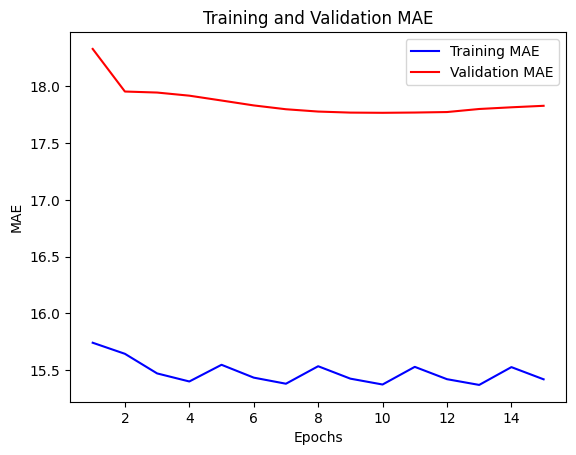

In [17]:
# 获取训练过程中的历史记录
train_accuracy = history.history['MAE']
val_accuracy = history.history['val_MAE']

# 绘制训练准确率和验证准确率随时间的变化图
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'b', label='Training MAE')
plt.plot(epochs, val_accuracy, 'r', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

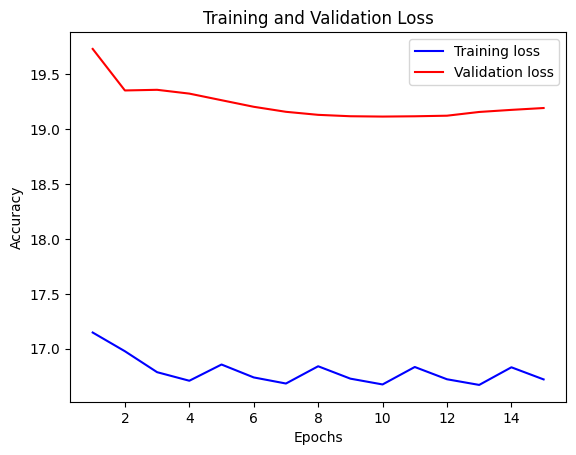

In [18]:
# 获取训练过程中的历史记录
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 绘制训练准确率和验证准确率随时间的变化图
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# x_train shape: (10, 42, 240, 240, 3) max: 255.0 min: 0.0
# y_train shape: (10, 42, 240, 240, 1) max: 255.0 min: 0.0
# x_test shape: (10, 3, 240, 240, 3) max: 255.0 min: 0.0

prediction = Model.predict(x_test)





# print(prediction)



In [ ]:
n = 0
plt.subplot(1, 5, 1)
plt.imshow(x_test[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(x_test[n, 0, :, :, 1], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(x_test[n, 0, :, :, 2], cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(prediction[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(y_test[n, 0, :, :, 0], cmap='gray')




In [ ]:
n = 1
plt.subplot(1, 5, 1)
plt.imshow(x_test[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(x_test[n, 0, :, :, 1], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(x_test[n, 0, :, :, 2], cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(prediction[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(y_test[n, 0, :, :, 0], cmap='gray')

In [ ]:
n = 2
plt.subplot(1, 5, 1)
plt.imshow(x_test[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(x_test[n, 0, :, :, 1], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(x_test[n, 0, :, :, 2], cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(prediction[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(y_test[n, 0, :, :, 0], cmap='gray')

In [ ]:
n = 3
plt.subplot(1, 5, 1)
plt.imshow(x_test[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(x_test[n, 0, :, :, 1], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(x_test[n, 0, :, :, 2], cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(prediction[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(y_test[n, 0, :, :, 0], cmap='gray')

In [ ]:
n = 4
plt.subplot(1, 5, 1)
plt.imshow(x_test[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(x_test[n, 0, :, :, 1], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(x_test[n, 0, :, :, 2], cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(prediction[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(y_test[n, 0, :, :, 0], cmap='gray')

In [ ]:
plt.subplot(3, 5, 1)
plt.imshow(x_test[0, 0, :, :, 0], cmap='gray')
plt.subplot(3, 5, 2)
plt.imshow(x_test[0, 0, :, :, 1], cmap='gray')
plt.subplot(3, 5, 3)
plt.imshow(x_test[0, 0, :, :, 2], cmap='gray')
plt.subplot(3, 5, 4)
plt.imshow(prediction[0, 0, :, :, 0], cmap='gray')
plt.subplot(3, 5, 5)
plt.imshow(y_test[0, 0, :, :, 0], cmap='gray')

# plt.colorbar()
plt.axis('off')  # 关闭坐标轴
plt.show()


plt.subplot(3, 5, 1)
plt.imshow(x_test[0, 1, :, :, 0], cmap='gray')
plt.subplot(3, 5, 2)
plt.imshow(x_test[0, 1, :, :, 1], cmap='gray')
plt.subplot(3, 5, 3)
plt.imshow(x_test[0, 1, :, :, 2], cmap='gray')
plt.subplot(3, 5, 4)
plt.imshow(prediction[0, 1, :, :, 0], cmap='gray')
plt.subplot(3, 5, 5)
plt.imshow(y_test[0, 1, :, :, 0], cmap='gray')

# plt.colorbar()
plt.axis('off')  # 关闭坐标轴
plt.show()


plt.subplot(3, 5, 1)
plt.imshow(x_test[0, 2, :, :, 0], cmap='gray')
plt.subplot(3, 5, 2)
plt.imshow(x_test[0, 2, :, :, 1], cmap='gray')
plt.subplot(3, 5, 3)
plt.imshow(x_test[0, 2, :, :, 2], cmap='gray')
plt.subplot(3, 5, 4)
plt.imshow(prediction[0, 2, :, :, 0], cmap='gray')
plt.subplot(3, 5, 5)
plt.imshow(y_test[0, 2, :, :, 0], cmap='gray')

# plt.colorbar()
plt.axis('off')  # 关闭坐标轴
plt.show()

In [ ]:
print(x_train.shape)
n = 5
print(x_train[n:n+1,:,:,:,:].shape)
prediction = Model.predict(x_train[n:n+1,:,:,:,:])
n = 0
plt.subplot(1, 5, 1)
plt.imshow(x_test[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(x_test[n, 0, :, :, 1], cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(x_test[n, 0, :, :, 2], cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(prediction[n, 0, :, :, 0], cmap='gray')
plt.subplot(1, 5, 5)
plt.imshow(y_test[n, 0, :, :, 0], cmap='gray')